# 1 - References

- Reference: XGboot
https://github.com/dataquestio/project-walkthroughs/blob/master/bitcoin_price/prediction.ipynb  (https://www.youtube.com/watch?v=TF2Nx_ifmrU&t=2550s)

@online{XGBoost,
  author = {DataQuest},
  title = {Predict Bitcoin Prices With Machine Learning And Python [W/Full Code]},
  url = {https://www.youtube.com/watch?v=TF2Nx_ifmrU&t=2550s},
  note = {Available at \url{https://github.com/dataquestio/project-walkthroughs/tree/master/bitcoin_price}},
}


# 2 - Load Data

**WORK WITH TIME-SERIES DATA:**

1. Data preprocessing methodology work with Time-series data:
- This data is time series it's sequential, so we don't use Cross-Validation or any of the model ML techniques to evaluate error. TimeSeriesSplit, which is a specific type of cross-validation technique used for time series data. It's important to use time-series cross-validation when dealing with sequential data to avoid training on future data. TimeSeriesSplit splits the data into folds, so that the folds with data from the previous past will be used as the training set, and the future data will only be used as the test set. For example, if we split the data into 3 folds, each fold would consist of:
    - Fold 1: Data from January 2016 to December 2017 (training set) and data from January 2018 to December 2018 (test set).    
    - Fold 2: Data from January 2016 to December 2018 (training set) and data from January 2019 to December 2019 (test set).    
    - Fold 3: Data from January 2016 to December 2019 (training set) and data from January 2020 to December 2020 (test set). <br>

The code: `tscv = TimeSeriesSplit(n_splits=3)` will creat a time-series cross-validation object that splits the data into 3 folds in chronological order.


In [1]:
# Load Data
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/lavibula/GoldPricePrediction/main/data/data_preparation/merged_data/data_preparation.csv")

# Use BTC_close_tomorrow -> y (Target col) of X_today, BTC_close_today -> 1 feature in X_today.
data["GOLD_close_tomor"] = data["GOLD_close"].shift(-1)
data = data.iloc[:-1] # data = data.drop(data.index[-1]) # Xóa hàng cuối
data

,Date,GOLD_open,GOLD_high,GOLD_low,GOLD_close,copper,crude_oil,DXY,EURUSD,MSCI,NASDAQ,NLR,RUT,silver,SP500,VIX,GOLD_close_tomor
0,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,1760.71,23.285,4358.34,14.91,1999.2
1,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,1760.71,23.285,4358.34,14.91,1999.2
2,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,1760.71,23.285,4358.34,14.91,1999.2
3,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,1760.71,23.285,4358.34,14.91,1999.2
4,2023-11-03,1993.5,2011.9,1989.3,1999.2,3.6815,80.51,105.02,1.0732,497.76,13478.28,71.36,1760.71,23.285,4358.34,14.91,1999.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3517,2010-04-06,1131.9,1139.6,1123.5,1136.0,3.6170,86.84,81.39,1.3400,37.37,2436.81,70.59,701.48,17.931,1189.44,16.23,1136.0
3518,2010-04-06,1131.9,1139.6,1123.5,1136.0,3.6170,86.84,81.39,1.3400,37.37,2436.81,70.59,701.48,17.931,1189.44,16.23,1133.8
3519,2010-04-05,1122.0,1134.3,1120.8,1133.8,3.6315,86.62,81.09,1.3487,36.98,2429.53,70.44,697.65,18.118,1187.44,17.02,1133.8
3520,2010-04-05,1122.0,1134.3,1120.8,1133.8,3.6315,86.62,81.09,1.3487,36.98,2429.53,70.44,697.65,18.118,1187.44,17.02,1126.1


Split Data: Last 250 days for Test.
Train set with GirdSearch and RandomizedSearch to find best parameters, and Test set for Test. (I don't split: Train, Valid, Test)

In [3]:
data.columns

Index(['Date', 'GOLD_open', 'GOLD_high', 'GOLD_low', 'GOLD_close', 'copper',
       'crude_oil', 'DXY', 'EURUSD', 'MSCI', 'NASDAQ', 'NLR', 'RUT', 'silver',
       'SP500', 'VIX', 'GOLD_close_tomor'],
      dtype='object')

In [4]:
train = data.iloc[:-250]
test = data.iloc[-250:]

predictors = ['GOLD_open', 'GOLD_high', 'GOLD_low', 'GOLD_close', 'copper',
       'crude_oil', 'DXY', 'EURUSD', 'MSCI', 'NASDAQ', 'NLR', 'RUT', 'silver',
       'SP500', 'VIX']  # not BTC_close_tomorrow

# 3 - Train Model: XGBoost Classification. (Extreme Gradient Boosting)

## 3.0 Định nghĩa và đóng gói hàm

XGBoost Regression model methodology:

2.1 Difinition:
- Ensemble Methods: method of combining multiple models (search gg Machine Learning picture)    
    - Stacking techniques    
    - Bagging technique: Random Forest alg.  
    - Boosting technique: XGBoost, LightGBM, CatBoost, AdaBoost. Repeat the training process with different weights.        
        - XGBoost: regularization to reduce overfitting, gradient boosting to optimize tree weights, parallelization to train independent trees and speed up the training process, tools to monitor (giám sát) the training process.        
        - AdaBoost is the first boosting algorithm, CatBoost focuses on feature categorical (tính phân loại) and LightGBM focuses on speed and scalability for large datasets.
        
2.2 How does the XGBoost model work?

The goal of the XGBoost model is to optimize the loss function, minimizing the difference between the predicted value and the actual value.
- The loss function of XGBoost is the sum of the loss functions of each tree in the population (quần thể), including the loss function of the regularization terms(thuật ngữ chính quy).

The main formula of the loss function in XGBoost is:

$Obj^{(t)}=\sum_{i=1}^{n}l(y_i, \hat{y}_i^{(t-1)}+f_t(x_i))+\Omega(f_t) $

In there:
- $Obj^{(t)}$ is the loss function value at the t_th loop.
- $n$ is the number of training data points.
- $y_i$ is the target value of the i-th data point.
- $\hat{y}_i^{(t-1)}$ is the predicted value of the model at the previous loop t-1.
- $f_t(x_i)$ is the predicted value of the t tree on the ith data point.
- $l(y_i, \hat{y}_i^{(t-1)}+f_t(x_i))$ is a loss function, which measures the difference between the predicted value and the actual value economy on the i-th data point.
- $\Omega(f_t)$ is the regularization term (hàm chi phí), which measures the complexity of the t-th tree.

- XGBoost use: regularization to reduce overfitting, gradient boosting to optimize tree weights, parallelization to train independent trees and speed up the training process, tools to monitor (giám sát) the training process.   

In [5]:
# Đóng gói def Evaluate_Model and def Plot_Model
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test):
  """
  parameters: `y_test`, `y_pred_test`
  calculates evaluation metrics,
    including R-squared, MSE, RMSE, MAE, MAPE,
      and directional accuracy (DA)
  """
  print('EVALUATE METRICS ON THE TRAIN SET')
  print('Coefficient of determination R2:', r2_score(y_train, y_pred_train)) # print(model.score(X_test, y_train))
  print('Mean Squared Error MSE:', mean_squared_error(y_train, y_pred_train))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_train, y_pred_train))
  MAPE = mean_absolute_percentage_error(y_train, y_pred_train)
  # MAPE = np.mean(np.abs((np.array(y_train) - np.array(y_pred_train)) / y_train))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%", '\n')

  print('EVALUATE METRICS ON THE TEST SET')
  print('Coefficient of determination R2:', r2_score(y_test, y_pred_test)) # print(model.score(X_test, y_test))
  print('Mean Squared Error MSE:', mean_squared_error(y_test, y_pred_test))
  print('Root Mean Squared Error RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
  print('Mean Absolute Error MAE:', mean_absolute_error(y_test, y_pred_test))
  MAPE = mean_absolute_percentage_error(y_test, y_pred_test)
  # MAPE = np.mean(np.abs((np.array(y_test) - np.array(y_pred_test)) / y_test))
  print('Mean Absolute Percentage Error MAPE%', f"{round(MAPE*100, 4)}%")

def Plot_Model(y_test, y_pred_test, num_samples):
  """
  Scatter Plot(Biểu đồ phân tán) with x_axis: y_test, y_axis: y_pred_test
  Print test_pred_df
  Line Plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  """
  # Gộp 2 Plot scatterplot and lineplot
  plt.subplots(figsize=(15,7)) # return tuple (Figure, Axes). obj Figure: toàn bộ hình ảnh, obj Axes: các vùng trực quan.
  ax1 = plt.subplot(121)
  ax2 = plt.subplot(122)

  # Scatter plot
  ax1.scatter(y_test, y_pred_test)
  ax1.set_title("Predictions vs Actual")  #plt.title
  ax1.set_xlabel("y_true")                #plt.xlabel
  ax1.set_ylabel("y_pred_test")           #plt.ylabel

  x = range(int(max(y_test))) #vẽ đường chéo giữa.
                              # type y_test from df: <class 'pandas.core.series.Series'>, tương tự df, but have only 1 col
  ax1.plot(x, 'r') # Opt speed, we can use x = np.arange(int(max(y_test))).astype(int)

  # Line plot with x_axis: position point, y_axis: Value and 2 line: y_test, y_pred_test
  #1 plot vẽ tập Test nhưng show ra x 6000 điểm -> vì plot ra index của hàng ban đầu.
  #2 Muốn plot ra tập sample với ít điểm giá trị hơn.
  #3 Muốn plot hiện điểm 1, 2, 3, ... chứ không phải điểm 0.0, 0.5, 1.0, ...
  test_pred_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test}) # Create df 3 col: index, y_test, y_pred_test
  test_pred_subset_df = pd.DataFrame({'y_test_few': y_test[:num_samples], 'y_pred_test_few': y_pred_test[:num_samples]}) #2
  test_pred_subset_df = test_pred_subset_df.reset_index(drop=True) #1 Add a reset index and Remove old index

  # sns.lineplot(data=test_pred_subset_df) # data = df
  sns.lineplot(data=test_pred_subset_df).set(xticks=range(0, num_samples+1, int(num_samples/5)+1))
                                        # set x_axis ticks (dấu kiểm) hiện ít điểm hơn trên x
  ax2.set_title("Test Predictions")
  ax2.set_xlabel("Point") # tên hàng
  ax2.set_ylabel("Value")
  plt.show() # show những plots above

# y_train = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_train = [-10, -15, -20, -25, -30, -35, -40]

# y_test = [10 , 15, 20, 25, 30, 35, 40]
# y_pred_test = [-10, -15, -20, -25, -30, -35, -40]
# Evaluate_Model(y_train, y_pred_train, y_test, y_pred_test)
# # Plot_Model(y_test, y_pred_test, 6)

## 3.1 simple RandomForestRegressor, XGBRegressor Model

In [7]:
# simple RandomForestRegressor Model
from sklearn.ensemble import RandomForestRegressor   #Ensemble Method
from sklearn.metrics import precision_score # ValueError: continuous is not supported, nhãn 0/1

rf_model = RandomForestRegressor(random_state=1, n_estimators=100, min_samples_split=50)
                               # số cây, individual decision tree should not split its nodes unless it has at least 50 samples.


rf_model.fit(train[predictors], train['GOLD_close_tomor'])

y_pred_train = rf_model.predict(train[predictors])
y_pred_test = rf_model.predict(test[predictors])
Evaluate_Model(train['GOLD_close_tomor'], y_pred_train, test['GOLD_close_tomor'], y_pred_test)

EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9995863846052732
Mean Squared Error MSE: 31.832549317657243
Root Mean Squared Error RMSE: 5.642034147154486
Mean Absolute Error MAE: 3.593255581300015
Mean Absolute Percentage Error MAPE% 0.2411% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.9958763232843197
Mean Squared Error MSE: 33.635183956828854
Root Mean Squared Error RMSE: 5.799584809003904
Mean Absolute Error MAE: 3.9534324626745474
Mean Absolute Percentage Error MAPE% 0.3095%


In [9]:
# SIMPLE XGBRegressor Model when hyperparameters have not been adjusted
from xgboost import XGBRegressor

xgb_model = XGBRegressor() # với các tham số mặc định
xgb_model.fit(train[predictors], train["GOLD_close_tomor"])

y_pred_train = rf_model.predict(train[predictors])
y_pred_test = rf_model.predict(test[predictors])
Evaluate_Model(train['GOLD_close_tomor'], y_pred_train, test['GOLD_close_tomor'], y_pred_test)


EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9995863846052732
Mean Squared Error MSE: 31.832549317657243
Root Mean Squared Error RMSE: 5.642034147154486
Mean Absolute Error MAE: 3.593255581300015
Mean Absolute Percentage Error MAPE% 0.2411% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.9958763232843197
Mean Squared Error MSE: 33.635183956828854
Root Mean Squared Error RMSE: 5.799584809003904
Mean Absolute Error MAE: 3.9534324626745474
Mean Absolute Percentage Error MAPE% 0.3095%


Hyperparameter Tuning

In [10]:
# Some parmaters XGB with GridSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np

xgb = XGBRegressor() # XGBoost

# Lựa chọn giá trị siêu tham số: dựa vào data và value thông thường XGBoost
param_grid = {'random_state': [1],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3,5,7],
#      'colsample_bytree': [0.7, 0.8, 0.9],
#       'subsample': [0.7, 0.8, 0.9],
#       'gamma'
#       'min_child_samples': [1, 5, 10]
}

# thay đổi cv sang TimeSeriesSplit-specific tyoe of cv tech used for time series-
tscv = TimeSeriesSplit(n_splits=3)
grid_search_model = GridSearchCV(estimator=xgb, # model ước lượng
                           param_grid=param_grid,
                           cv=tscv, ) # sử dụng TimeSeriesSplit

# fit, Find best hyperparameters.
grid_search_model.fit(train[predictors], train['GOLD_close_tomor'])
print("Best parameters found: ", grid_search_model.best_params_)

best_xgb_model = grid_search_model.best_estimator_  #set: best_xgb_model with best_estimator.

y_pred_train = rf_model.predict(train[predictors])
y_pred_test = rf_model.predict(test[predictors])
Evaluate_Model(train['GOLD_close_tomor'], y_pred_train, test['GOLD_close_tomor'], y_pred_test)

# 0.5299145299145299 - Bitcoin Prediction ???


Best parameters found:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 150, 'random_state': 1}
EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9995863846052732
Mean Squared Error MSE: 31.832549317657243
Root Mean Squared Error RMSE: 5.642034147154486
Mean Absolute Error MAE: 3.593255581300015
Mean Absolute Percentage Error MAPE% 0.2411% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.9958763232843197
Mean Squared Error MSE: 33.635183956828854
Root Mean Squared Error RMSE: 5.799584809003904
Mean Absolute Error MAE: 3.9534324626745474
Mean Absolute Percentage Error MAPE% 0.3095%


In [11]:
# All parmaters XGB with RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import numpy as np

xgb = XGBRegressor() # XGBoost

# Lựa chọn giá trị siêu tham số: dựa vào data và value thông thường XGBoost

param_xgb = {
    'random_state': [1],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [i for i in range(50, 1000, 50)], # số cây, tăng độ chính xác, giảm overfitting
    'max_depth': [i for i in range(3,20)], # độ sâu tối đa
    'subsample': [0.5, 0.7, 0.8, 1], #tỷ lệ các mẫu cho mỗi cây
    'colsample_bytree': [0.5, 0.7, 1], # tỷ lệ features được dùng cho mỗi cây
    'gamma':[0, 0.1, 0.2, 0.3],
    'min_child_samples': [5, 10, 20] # só lượng mẫu tối thiểu được yêu cầu để tách 1 node
}


# thay đổi cv sang TimeSeriesSplit-specific tyoe of cv tech used for time series-
tscv = TimeSeriesSplit(n_splits=3)
random_search_model = RandomizedSearchCV(estimator=xgb, # model ước lượng
                           param_distributions=param_xgb,
                           cv=tscv, ) # sử dụng TimeSeriesSplit

# fit, Find best hyperparameters.
random_search_model.fit(train[predictors], train['GOLD_close_tomor'])
print("Best parameters found: ", grid_search_model.best_params_)

best_xgb_model = random_search_model.best_estimator_  #set: best_xgb_model with best_estimator.

y_pred_train = rf_model.predict(train[predictors])
y_pred_test = rf_model.predict(test[predictors])
Evaluate_Model(train['GOLD_close_tomor'], y_pred_train, test['GOLD_close_tomor'], y_pred_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:59:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:59:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:59:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_samples" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:59:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_child_s

Best parameters found:  {'subsample': 0.7, 'random_state': 1, 'n_estimators': 900, 'min_child_samples': 20, 'max_depth': 17, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 1}
EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9995863846052732
Mean Squared Error MSE: 31.832549317657243
Root Mean Squared Error RMSE: 5.642034147154486
Mean Absolute Error MAE: 3.593255581300015
Mean Absolute Percentage Error MAPE% 0.2411% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.9958763232843197
Mean Squared Error MSE: 33.635183956828854
Root Mean Squared Error RMSE: 5.799584809003904
Mean Absolute Error MAE: 3.9534324626745474
Mean Absolute Percentage Error MAPE% 0.3095%


# 4 - SUM

Model: XGBoost
Adjusting hyperparameters USING GRID SEACH AND RANDOMIZED SEARCH we get a model that is not much better than the XGBRegressor() model with default parameters.

Điều chỉnh siêu tham số BẰNG GRID SEACH VÀ RANDOMIZED SEARCH ta thu được model tốt không hơn mấy so với XGBRegressor() model với các tham số mặc định.




| Metrics | Train Set | Test Set |
| --- | --- | --- |
| R2 | 0.9996 | 0.9959 |
| MSE | 31.8325 | 33.6352 |
| RMSE | 5.6420 | 5.7995 |
| MAE | 3.5933 | 3.9534 |
| MAPE% | 0.2411% | 0.3095% |




EVALUATE METRICS ON THE TRAIN SET
Coefficient of determination R2: 0.9995863846052732
Mean Squared Error MSE: 31.832549317657243
Root Mean Squared Error RMSE: 5.642034147154486
Mean Absolute Error MAE: 3.593255581300015
Mean Absolute Percentage Error MAPE% 0.2411% 

EVALUATE METRICS ON THE TEST SET
Coefficient of determination R2: 0.9958763232843197
Mean Squared Error MSE: 33.635183956828854
Root Mean Squared Error RMSE: 5.799584809003904
Mean Absolute Error MAE: 3.9534324626745474
Mean Absolute Percentage Error MAPE% 0.3095%


<ipython-input-5-b146a923c3f7>:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121)


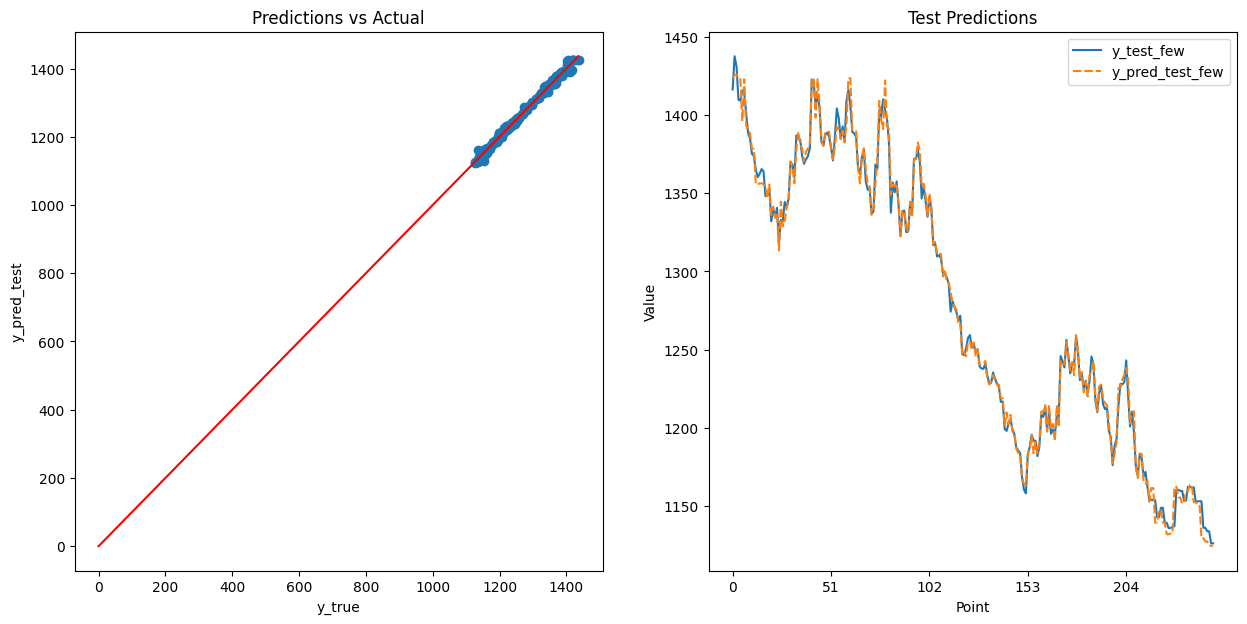

In [12]:
# SIMPLE XGBClassifier Model when hyperparameters have not been adjusted
from xgboost import XGBRegressor

xgb_model = XGBRegressor() # với các tham số mặc định
xgb_model.fit(train[predictors], train["GOLD_close_tomor"])

y_pred_train = rf_model.predict(train[predictors])
y_pred_test = rf_model.predict(test[predictors])
Evaluate_Model(train['GOLD_close_tomor'], y_pred_train, test['GOLD_close_tomor'], y_pred_test)
Plot_Model(test['GOLD_close_tomor'], y_pred_test, len(test['GOLD_close_tomor']))